# Installation and Setup

In [1]:
!pip install opendatasets -q
print("Opendatasets installed successfully.")
!pip install ultralytics -q
print("Ultralytics installed successfully.")

Opendatasets installed successfully.
Ultralytics installed successfully.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch

import opendatasets as od
from ultralytics import YOLO

from glob import glob
from google.colab import files

import time
import json
import os
from collections import defaultdict

from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

CUDA Available: True
GPU Name: Tesla T4


# Loading the data

In [4]:
files.upload()  # Select kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"omersalem","key":"5cac1ba8608ef02937eec35cc62b01c3"}'}

In [5]:
!mkdir -p ~/.kaggle

In [6]:
!mv kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Example: BDD100K YOLO dataset
od.download("https://www.kaggle.com/datasets/a7madmostafa/bdd100k-yolo")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omersalem
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/a7madmostafa/bdd100k-yolo


100%|██████████| 5.33G/5.33G [01:37<00:00, 58.4MB/s]


In [9]:
path = "/content/bdd100k-yolo"
yaml_path = "/content/bdd100k-yolo/data.yaml"
output_dir = "/content/bdd100k-yolo/runs/Evaluation"
weighs_path = "/content/best.pt"

In [10]:
def check_data(path, split):
    num_images = len(glob(f"{path}/{split}/images/*"))
    num_labels = len(glob(f"{path}/{split}/labels/*"))
    return num_images, num_labels

In [11]:
for split in ['train', 'val', 'test']:
    images, labels = check_data(path, split)
    print(f"{split.capitalize()} → Images: {images}, Labels: {labels}")

Train → Images: 70000, Labels: 70000
Val → Images: 10000, Labels: 10000
Test → Images: 20000, Labels: 20000


In [12]:
with open(yaml_path, "r") as f:
    data = f.read().replace("/kaggle/input/bdd100k-yolo", "/content/bdd100k-yolo")

with open(yaml_path, "w") as f:
    f.write(data)

print("✅ YAML updated successfully!")

✅ YAML updated successfully!


# Viualize the Model metrics after 45 epoch

In [14]:
CSV_FILE_PATH = '/content/Results.xlsx'
df = pd.read_excel(CSV_FILE_PATH)
x_axis = 'epoch'
print(f"Successfully loaded data from {CSV_FILE_PATH} with {len(df)} epochs.")

Successfully loaded data from /content/Results.xlsx with 45 epochs.


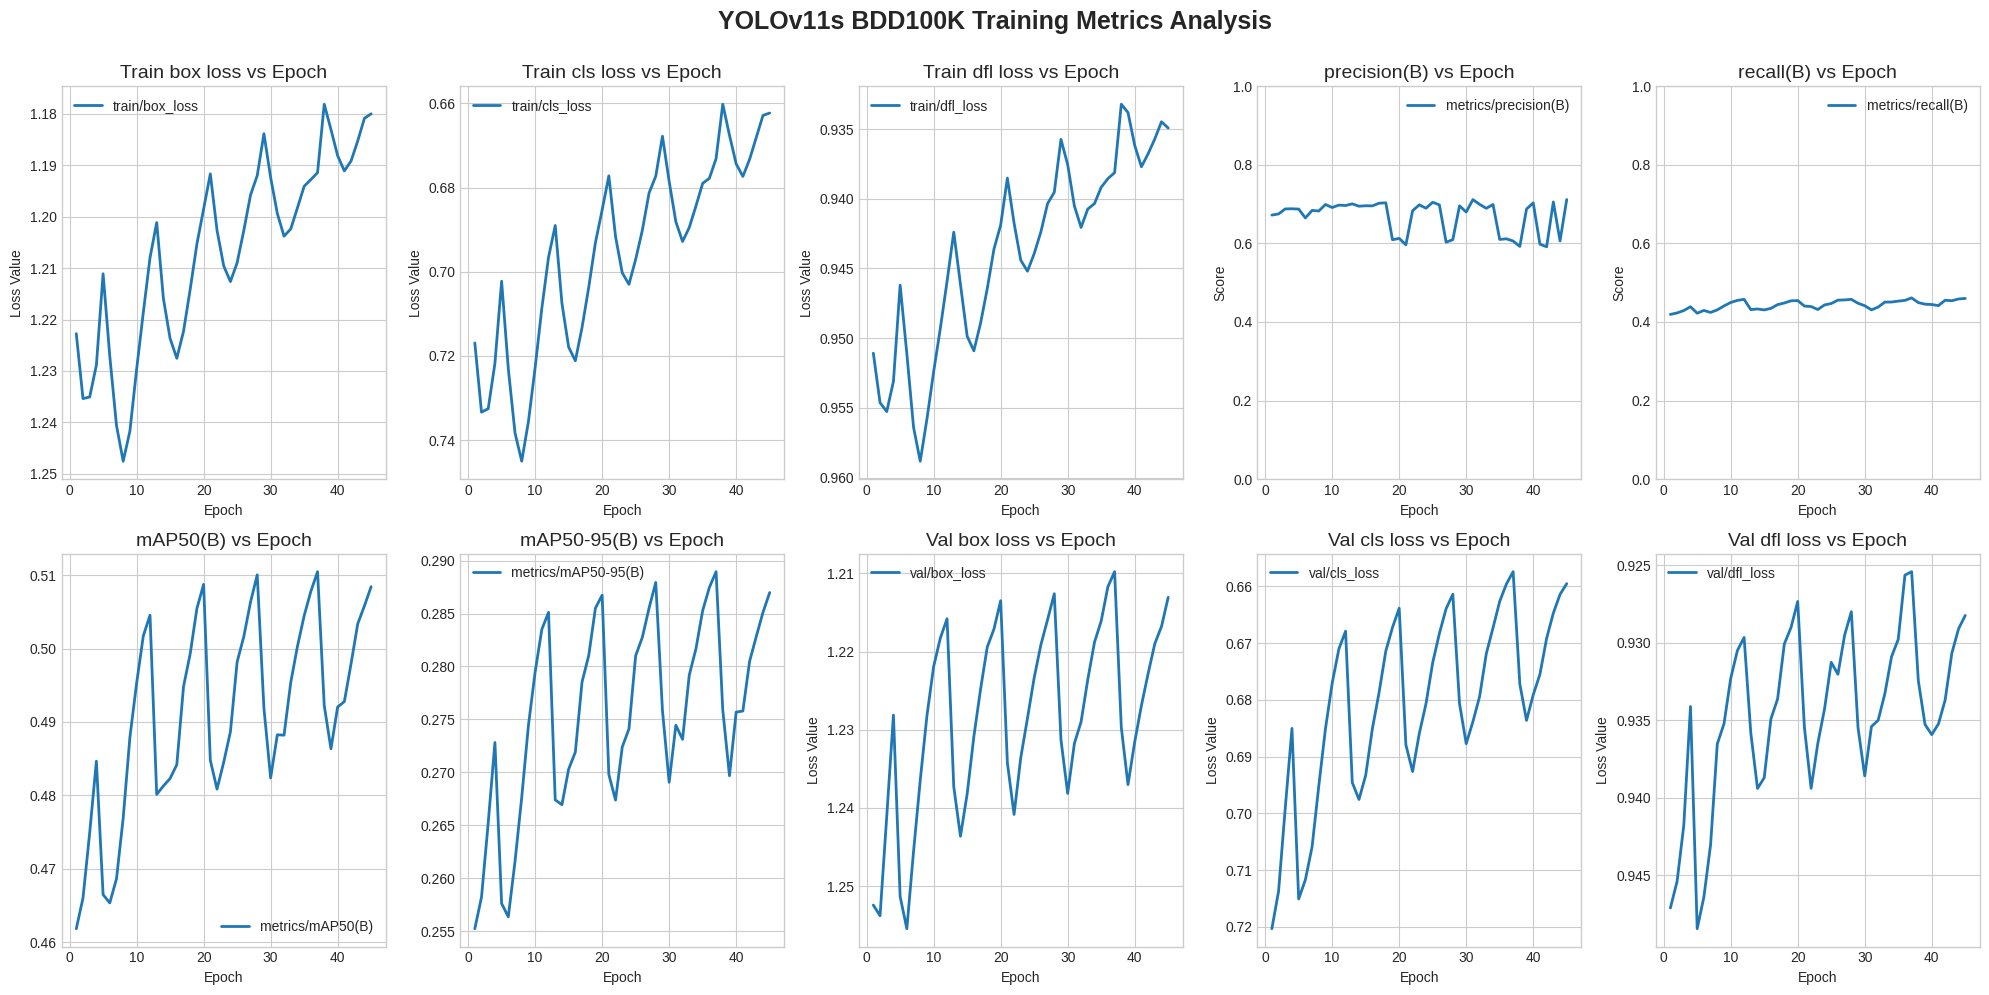

In [15]:
# The X-axis data is always the 'epoch' column (index 0)
metrics_to_plot = df.columns[2:12].tolist()
x_col = df.columns[0]
n = len(metrics_to_plot) # Number of plots to create (10)
rows = int(np.ceil(n / 5)) # Calculate rows needed for 4 columns per row

# --- 3. Plotting Loop (Simplified Iterative Style) ---

plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(rows, 5, figsize=(20, 5 * rows))
axs = axs.flatten()

for i, c in enumerate(metrics_to_plot):
    ax = axs[i]

    # Plotting the metric against the epoch
    ax.plot(df[x_col], df[c], label=c, linewidth=2)

    # Clean up the title (e.g., 'metrics/mAP50(B)' -> 'mAP50(B)')
    title = c.replace('metrics/', '').replace('train/', 'Train ').replace('val/', 'Val ').replace('_', ' ')

    ax.set_title(f'{title} vs Epoch', fontsize=14)
    ax.set_xlabel(x_col.title())
    ax.legend(loc='best')

    # Customize axis based on metric type
    if 'loss' in c.lower():
        ax.set_ylabel('Loss Value')
        ax.invert_yaxis() # Invert loss axis for better visualization of convergence
    elif 'mAP' in c.lower() or 'precision' in c.lower() or 'recall' in c.lower():
        ax.set_ylabel('Score')
        ax.set_ylim(0, 1) # Set limits for accuracy metrics


# --- Remove any unused subplots ---
if n % 5 != 0:
    for j in range(n, rows * 5):
        fig.delaxes(axs[j])

# --- Finalize and Display ---
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.suptitle('YOLOv11s BDD100K Training Metrics Analysis', x=0.5, y=1.02, fontsize=18, fontweight='bold')
plt.show()

# Evaluation

In [16]:
try:
    model = YOLO(weighs_path)
    print(f"Successfully loaded model from {weighs_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

Successfully loaded model from /content/best.pt


In [17]:
print("Starting FINAL evaluation on BDD100K")
start_time = time.time()

metrics = model.val(
    data=yaml_path,                    # must point to official test set
    imgsz=640,
    batch=16,
    split='test',
    device=0,
    half=True,
    conf=0.001,
    iou=0.5,
    plots=True,
    save_json=True,
    save_hybrid=False,
    project="final_milestone_results",
    name="BDD100K_TEST_OFFICIAL",
    exist_ok=True,
    verbose=True
)

end_time = time.time()
print(f"Evaluation completed in {(end_time - start_time)/60:.1f} minutes")

Starting FINAL evaluation on BDD100K
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,416,670 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 23.4±9.3 MB/s, size: 51.9 KB)
val: Scanning /content/bdd100k-yolo/test/labels... 20000 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 20000/20000 665.1it/s 30.1s
val: /content/bdd100k-yolo/test/images/e6f10c58-c46de527.jpg: 1 duplicate labels removed
val: New cache created: /content/bdd100k-yolo/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1250/1250 6.4it/s 3:14
                   all      20000     367727      0.631      0.488      0.523      0.288
                person       6213      24650      0.716      0.551       0.61        0.3
                 rider       1004       129

In [18]:
# Overall precision, recall, mAP
precision, recall, mAP50, mAP50_95 = metrics.box.mean_results()
df_metrics = pd.DataFrame([{
    'Precision': precision,
    'Recall': recall,
    'mAP@0.5': mAP50,
    'mAP@0.5-0.95': mAP50_95
}])
df_metrics.T

,0
Precision,0.631031
Recall,0.488215
mAP@0.5,0.522602
mAP@0.5-0.95,0.287695


In [19]:
data = []
for class_id, map_val in enumerate(metrics.box.maps):
    class_name = metrics.names[class_id]
    data.append({'Class': class_name, 'mAP50': map_val})
df_map = pd.DataFrame(data)
df_map


,Class,mAP50
0,person,0.300463
1,rider,0.222881
2,car,0.482466
3,bus,0.424891
4,truck,0.443557
5,bike,0.212469
6,motor,0.218615
7,traffic light,0.216852
8,traffic sign,0.333163
9,train,0.021589


## Claculating the IoU Manually

In [20]:
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2]-box1[0]) * (box1[3]-box1[1])
    box2Area = (box2[2]-box2[0]) * (box2[3]-box2[1])
    return interArea / (box1Area + box2Area - interArea + 1e-6)

In [21]:
predictions_path = "/content/final_milestone_results/BDD100K_TEST_OFFICIAL/predictions.json"

with open(predictions_path) as f:
    annotations = json.load(f)  # flat list of predictions

In [22]:
labels_dir = "/content/bdd100k-yolo/test/labels"
gt_boxes = {}  # {image_name: [{'box':[x1,y1,x2,y2], 'class':int}, ...]}

for label_file in os.listdir(labels_dir):
    if not label_file.endswith('.txt'):
        continue
    image_name = label_file.replace('.txt','.jpg')
    boxes = []
    with open(os.path.join(labels_dir, label_file)) as f:
        for line in f:
            cls, x_center, y_center, w, h = map(float, line.strip().split())
            # convert from YOLO normalized to absolute coordinates (adjust image size)
            x1 = (x_center - w/2) * 1280
            y1 = (y_center - h/2) * 720
            x2 = (x_center + w/2) * 1280
            y2 = (y_center + h/2) * 720
            boxes.append({'class': int(cls), 'box': [x1, y1, x2, y2]})
    gt_boxes[image_name] = boxes

In [23]:
ious_per_class = defaultdict(list)

for ann in annotations:
    image_name = ann['file_name']
    x1, y1, w, h = ann['bbox']
    pbox_xyxy = [x1, y1, x1+w, y1+h]

    if image_name not in gt_boxes:
        continue

    # Compute IoU with all GT boxes
    ious_all = [compute_iou(pbox_xyxy, g['box']) for g in gt_boxes[image_name]]
    if not ious_all:
        continue

    best_iou = max(ious_all)
    best_gt = gt_boxes[image_name][ious_all.index(best_iou)]

    # Record IoU under the GT box's class
    ious_per_class[best_gt['class']].append(best_iou)

In [24]:
names = model.names

data = []
for cls_id, ious in ious_per_class.items():
    avg_iou = sum(ious)/len(ious) if ious else 0
    data.append({'Class': names[cls_id], 'Average_IoU': avg_iou})

# Create DataFrame
df_ious = pd.DataFrame(data)

# Display
df_ious

,Class,Average_IoU
0,car,0.234344
1,bus,0.267065
2,traffic light,0.161928
3,person,0.298302
4,traffic sign,0.184312
5,rider,0.281217
6,bike,0.324527
7,truck,0.256029
8,motor,0.337078
9,train,0.083090


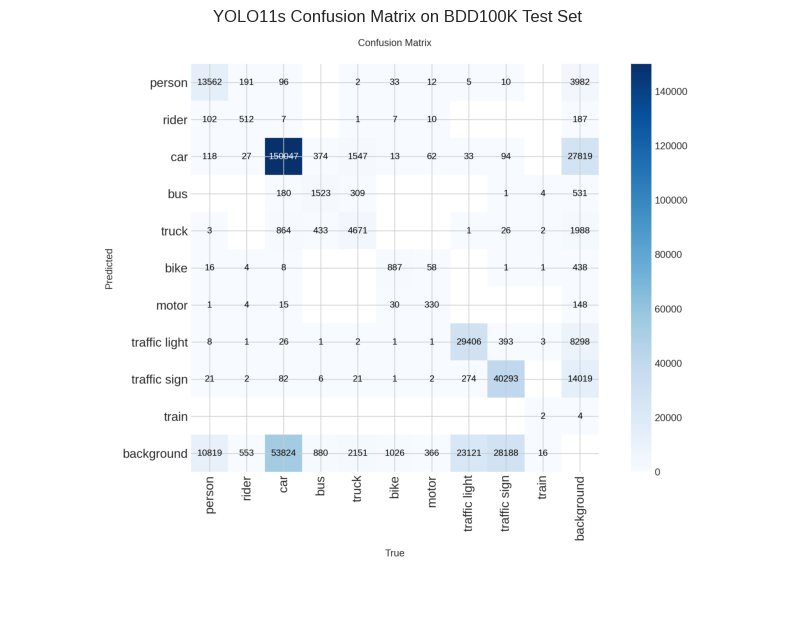

In [25]:

cm_path = "/content/final_milestone_results/BDD100K_TEST_OFFICIAL/confusion_matrix.png"
img = mpimg.imread(cm_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.title("YOLO11s Confusion Matrix on BDD100K Test Set")
plt.show()

In [26]:
import shutil

# Zip the folder
shutil.make_archive("/content/BDD100K_TEST_OFFICIAL", 'zip', "/content/final_milestone_results/BDD100K_TEST_OFFICIAL")

# Download the zip
files.download("/content/BDD100K_TEST_OFFICIAL.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>